# Machine Learning and AI for Autonomous Systems
## A program by IISc and TalentSprint
### Mini Project: Image classification using MLP and CNN

## Learning Objectives

At the end of the experiment, you will be able to :

* load and extract features of images

* implement the Multi-Layer perceptron to classify images

* implement CNN using keras

## Introduction

Traffic sign recognition is a challenging, real-world problem relevant for AI based transportation systems. Traffic signs show a wide range of variations between classes in terms of color, shape, and the presence of pictograms or text. However, there exist subsets of
classes (e.g., speed limit signs) that are very similar to each other. Further, the classifier
has to be robust against large variations in visual appearances due to changes in illumination, partial
occlusions, rotations, weather conditions etc. Using a comprehensive traffic sign detection dataset, here we will perform classification of traffic signs, train and evaluate the different models and compare to the performance of MLPs.

![img](https://paperswithcode.com/media/datasets/GTSRB-0000000633-9ce3c5f6_Dki5Rsf.jpg)

## Dataset

The data for this mini-project is from the German Traffic Sign Detection Benchmark [GTSDB](https://benchmark.ini.rub.de/gtsdb_dataset.html). This archive contains the training set used during the IJCNN 2013 competition.

The German Traffic Sign Detection Benchmark is a single-image detection assessment for researchers with interest in the field of computer vision, pattern recognition and image-based driver assistance. It is introduced on the IEEE International Joint Conference on Neural Networks 2013.

It features ...

* The main archive FullIJCNN2013.zip includes the images (1360 x 800 pixels) in PPM format, the image sections containing only the traffic signs
* A file in CSV format with the ground truth
* A ReadMe.txt with more details.

## Problem Statement

To build and improve upon a machine learning model for the classification of images and achieve a high accuracy final model.

## Grading = 10 Points

In [2]:
#@title Download the data
!wget -qq https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip
!unzip -qq FullIJCNN2013.zip

### Import Required packages

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from skimage.io import imread, imshow
from sklearn import preprocessing
import os, glob
from PIL import Image
from sklearn.model_selection import GridSearchCV
# Keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score, classification_report
from keras.regularizers import l2

###**Excercise 1**

### Data Loading and Feature Extraction (1 points)

#### Get the features and labels of data

* Extract the features of the images
* Extract labels of the images
* Resize the images to (30, 30) and convert to numpy 1-D array

   Hint: [Link](https://machinelearningmastery.com/how-to-load-and-manipulate-images-for-deep-learning-in-python-with-pil-pillow/)

In [43]:
import os
from PIL import Image
import numpy as np
from sklearn.preprocessing import LabelEncoder

dataset_path = "/content/FullIJCNN2013"  # Replace with your dataset path
image_size = (30, 30)  # Target size

image_features = []
image_features_normalized = []
image_labels = []
class_samples = {}
class_counts = {}

for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    if os.path.isdir(label_path):
        for image_name in os.listdir(label_path):
            if image_name.endswith(".ppm"):
                image_path = os.path.join(label_path, image_name)
                try:
                    with Image.open(image_path) as img:
                        img_resized = img.resize(image_size)
                        class_samples[label] = img_resized
                        class_counts[label] = len([img for img in os.listdir(label_path)])

                        img_array = np.array(img_resized)

                        img_flattened = img_array.flatten()
                        img_normalized = normalize([img_flattened])[0]

                        image_features.append(img_flattened)
                        image_features_normalized.append(img_normalized)
                        image_labels.append(label)
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")

image_features = np.array(image_features)
image_labels = np.array(image_labels)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(image_labels)

print(f"Features shape: {image_features.shape}")
print(f"Labels shape: {encoded_labels.shape}")

np.save("image_features.npy", image_features)
np.save("image_features_normalized.npy", image_features_normalized)
np.save("image_labels.npy", encoded_labels)


Features shape: (1213, 2700)
Labels shape: (1213,)


###**Excercise 2**
### Data Exploration and Preprocessing ( 2 points)

#### Plot the sample image of each class

Hint: plt.subplot

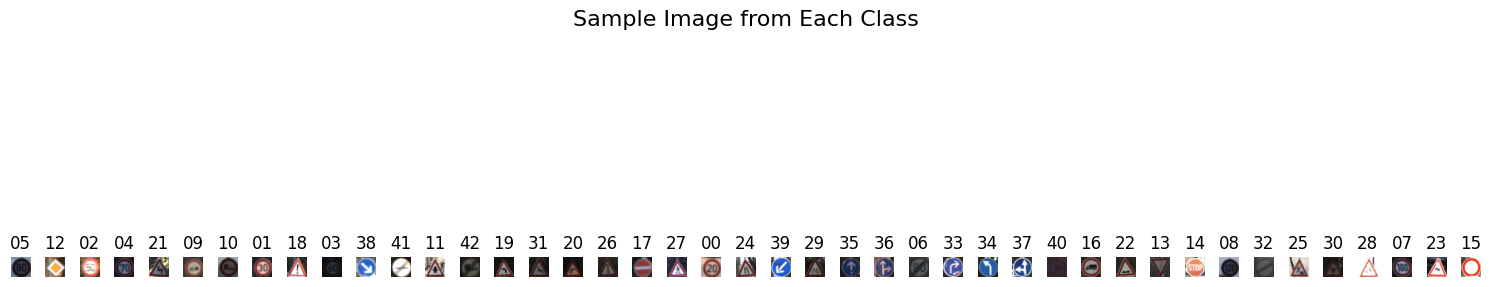

In [22]:
num_classes = len(class_samples)
fig, axes = plt.subplots(1, num_classes, figsize=(15, 5))
fig.suptitle("Sample Image from Each Class", fontsize=16)


for i, (label, img) in enumerate(class_samples.items()):
    ax = axes[i] if num_classes > 1 else axes  # Handle single-class case
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(label)

plt.tight_layout()
plt.show()

#### Plot the distribution of Classes

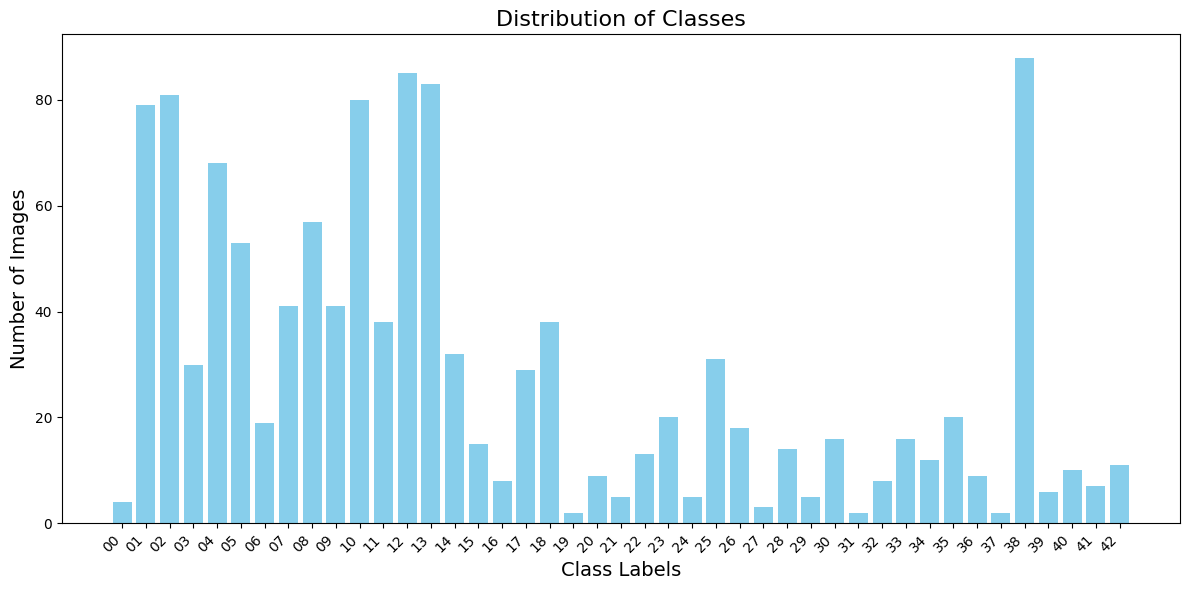

In [44]:
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[0]))

plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class Labels', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.title('Distribution of Classes', fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()

#### Normalize the features

For most image data, the pixel values are integers with values between 0 and 255.

Neural networks process inputs using small weight values, and inputs with large integer values can disrupt or slow down the learning process. As such it is good practice to normalize the pixel values.

Hint: sklearn.preprocessing.normalize

In [ ]:
# YOUR CODE HERE

###**Excercise 3**
### Train the MLP classifier on features (3 points)

* Split the data into train and test

* Train the MLP classifier with different parameters

* Get the accuracy score and performance metrics



* Define the keras model and initialize the layers
  - Ensure the input layer has the right number of input features. This can be specified when creating the first layer with the input_dim argument.
* Compile the model
  - Specify the loss function (to evaluate a set of weights), the optimizer (is used to search through different weights for the network) and any optional metrics to collect and report during training.
* Fit and Evaluate the model
  - Fit the data by specifying epochs and evaluate the model

In [45]:
# Step 1 - Build the architecture
X = np.load("image_features_normalized.npy")
y = np.load("image_labels.npy")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=200, activation='relu', solver='adam', random_state=42)
mlp.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(128, 64), random_state=42)

In [ ]:
# Step 2 - Compile the model
# YOUR CODE HERE

In [47]:
# Step 3 - Fit and Evaluate the model
y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Sklearn MLP Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Sklearn MLP Accuracy: 0.8559670781893004
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.88      0.88      0.88        16
           2       0.89      1.00      0.94        16
           3       0.83      0.83      0.83         6
           4       0.92      0.86      0.89        14
           5       0.64      0.82      0.72        11
           6       1.00      0.50      0.67         4
           7       1.00      0.88      0.93         8
           8       0.82      0.82      0.82        11
           9       0.89      1.00      0.94         8
          10       1.00      1.00      1.00        16
          11       0.89      1.00      0.94         8
          12       0.88      0.88      0.88        17
          13       0.94      0.94      0.94        17
          14       0.75      1.00      0.86         6
          15       1.00      1.00      1.00         3
          16    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Try the different algorithms and compare the results with MLP classifier

###**Excercise 4**
### Train a CNN classifier on images (4 points)

* Split the data into train and test

* Train the CNN with 2D convolution and Maxpooling layers

* Get the accuracy score on train and test sets



* Define the keras model and initialize the layers
  - Ensure the input layer is specified with correct image size as input. This can be specified when creating the first layer with the input_shape argument.
* Speicify number of filters Kernel size, Pool size and activation function
  - filters,kernel_size and activation arguments of Conv2D layer can be used
  - pool_size argument of MaxPool2D can be used to set Pool size
* Compile the model
  - Specify the loss function (to evaluate a set of weights), the optimizer (is used to search through different weights for the network) and any optional metrics to collect and report during training.
* Fit and Evaluate the model
  - Fit the data by specifying epochs and evaluate the model

In [48]:
# Step 1 - Build the architecture
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
X = np.load("image_features_normalized.npy")  # Normalized image data
y = np.load("image_labels.npy")  # Labels

image_size = (30, 30, 3)
X = X.reshape(-1, *image_size)

unique_classes = np.unique(y)
class_mapping = {label: idx for idx, label in enumerate(unique_classes)}
y_encoded = np.array([class_mapping[label] for label in y])

y_onehot = to_categorical(y_encoded, num_classes=len(unique_classes))

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded)
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=image_size),  # First convolutional layer
    MaxPooling2D(pool_size=(2, 2)),  # First max-pooling layer
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),  # Second convolutional layer
    MaxPooling2D(pool_size=(2, 2)),  # Second max-pooling layer
    Flatten(),  # Flatten layer
    Dense(128, activation='relu'),  # Fully connected layer
    Dense(len(unique_classes), activation='softmax')  # Output layer for multi-class classification
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [49]:
# Step 2 - Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# 3. Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,  # Batch size
    verbose=1  # Show training progress
)


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.0533 - loss: 3.6695 - val_accuracy: 0.0658 - val_loss: 3.4515
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.0838 - loss: 3.4069 - val_accuracy: 0.0741 - val_loss: 3.3466
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.0712 - loss: 3.3832 - val_accuracy: 0.1193 - val_loss: 3.3243
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.0870 - loss: 3.3426 - val_accuracy: 0.1481 - val_loss: 3.2895
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.1294 - loss: 3.2993 - val_accuracy: 0.1728 - val_loss: 3.2071
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.2139 - loss: 3.1854 - val_accuracy: 0.2181 - val_loss: 3.0246
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.2764 - loss: 2.9435 - val_accuracy: 0.2963 - val_loss: 2.6968
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.3269 - loss: 2.5912 - val_accuracy: 0.4362 -

In [50]:
# Step 3 - Fit and Evaluate the model
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.8835051655769348
Test Accuracy: 0.7818930149078369


#### Experiment using Dropout, Regularization and Batch Normalization

In [55]:
model = Sequential([
    # First convolutional layer
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=image_size, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Second convolutional layer
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Flatten layer
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),

    # Output layer
    Dense(len(unique_classes), activation='softmax')
])

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=32,
    verbose=1
)

train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.1267 - loss: 7.0864 - val_accuracy: 0.0741 - val_loss: 6.5515
Epoch 2/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.4216 - loss: 5.1202 - val_accuracy: 0.0700 - val_loss: 6.3966
Epoch 3/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.5671 - loss: 4.2580 - val_accuracy: 0.0700 - val_loss: 6.2463
Epoch 4/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.6282 - loss: 3.8486 - val_accuracy: 0.0700 - val_loss: 6.0851
Epoch 5/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.7045 - loss: 3.3697 - val_accuracy: 0.0700 - val_loss: 5.9747
Epoch 6/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.7574 - loss: 3.0576 - val_accuracy: 0.1276 - val_loss: 5.8160
Epoch 7/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8335 - loss: 2.6154 - val_accuracy: 0.1317 - val_loss: 5.7047
Epoch 8/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.8577 - loss: 2.4005 - val_accuracy: 0.1440 -